### **Import potrzebnych bibliotek**

In [75]:
import pandas as pd
import numpy as np
!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
from scipy import stats
import re
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import scipy.stats as stats


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


### **Wstępne działania na danych**

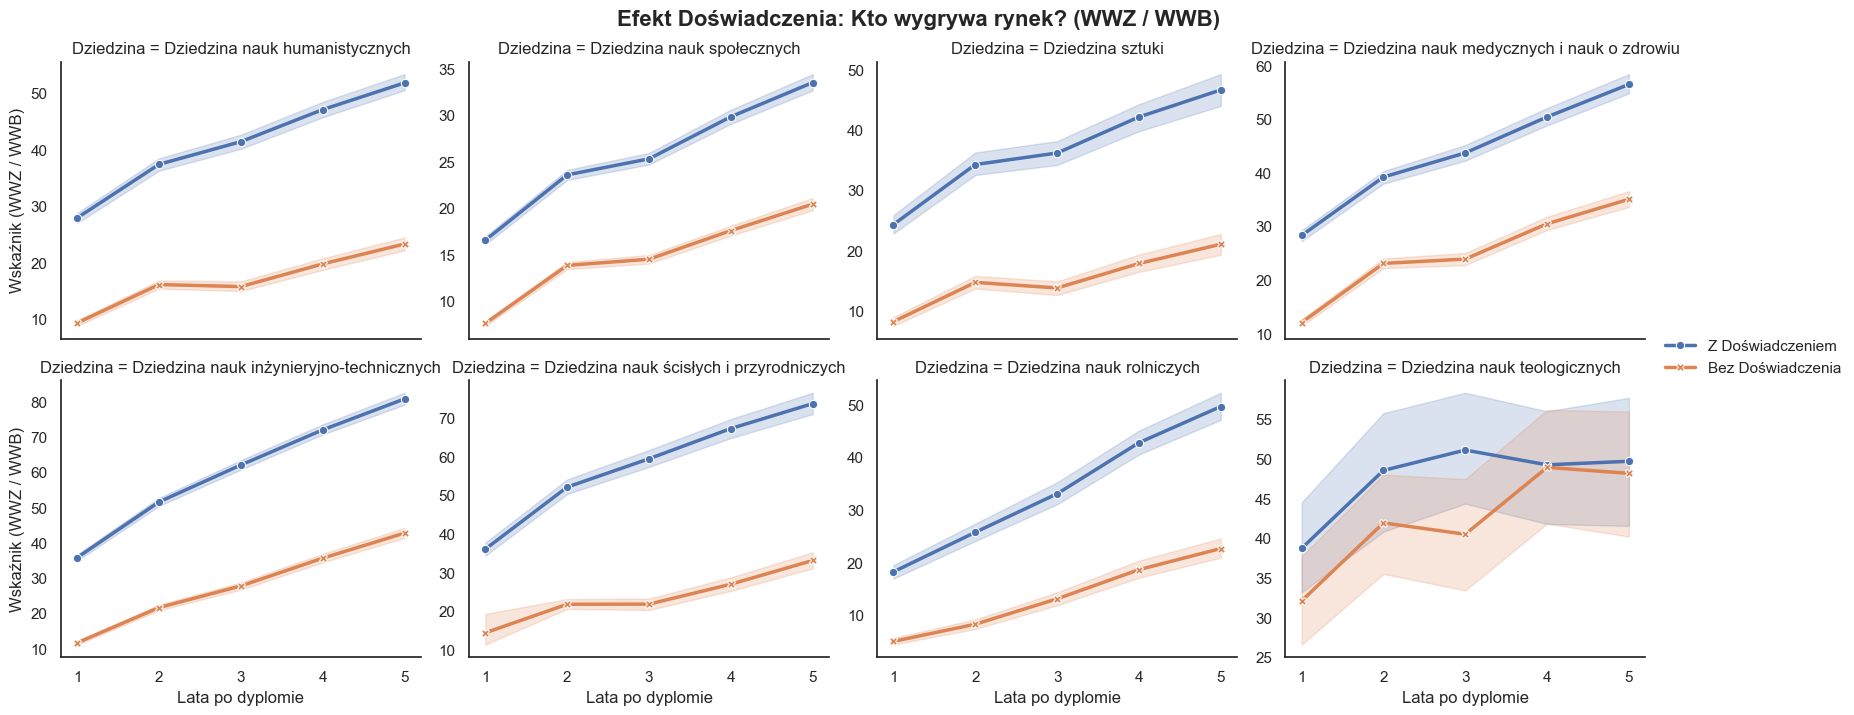


    GDZIE DOŚWIADCZENIE DAJE NAJWIĘKSZEGO KOPA? (Rok 5)    
P_DZIEDZINA
Dziedzina nauk ścisłych i przyrodniczych      39.565233
Dziedzina nauk inżynieryjno-technicznych      35.618224
Dziedzina nauk humanistycznych                28.513135
Dziedzina nauk rolniczych                     25.784130
Dziedzina sztuki                              23.774549
Dziedzina nauk medycznych i nauk o zdrowiu    19.434276
Dziedzina nauk społecznych                    12.387227
Dziedzina nauk teologicznych                   2.705488
Name: Premia_Doswiadczenia_P5, dtype: float64


In [ ]:
#     1. WCZYTANIE DANYCH (Nazwy w słowniku: P_WWZ_DOSW_P1 itd.)    
data_dir = Path('./data') # Dostosuj ścieżkę
file_path = data_dir / 'graduates-major-data.csv'

# Kolumny, które nas interesują (Zarobki i Bezrobocie dla obu grup)
cols_base = ['P_DZIEDZINA', 'P_NAZWA_UCZELNI']
cols_dosw = [f'P_WWZ_DOSW_P{i}' for i in range(1, 6)] + [f'P_WWB_DOSW_P{i}' for i in range(1, 6)]
cols_ndosw = [f'P_WWZ_NDOSW_P{i}' for i in range(1, 6)] + [f'P_WWB_NDOSW_P{i}' for i in range(1, 6)]

# Bezpieczne wczytywanie
df = pd.read_csv(
    file_path, 
    usecols=cols_base + cols_dosw + cols_ndosw, 
    sep=';', decimal=',', encoding='utf-8', on_bad_lines='skip'
)

# Konwersja na liczby (na wszelki wypadek)
for c in cols_dosw + cols_ndosw:
    df[c] = pd.to_numeric(df[c], errors='coerce')

#     2. OBLICZENIE NOWEGO WSKAŹNIKA (Return / Risk)    
# Uwaga: Dodajemy mały epsilon (0.01) do mianownika, żeby nie dzielić przez zero
epsilon = 0.01

for i in range(1, 6):
    # Grupa Z DOŚWIADCZENIEM
    df[f'Index_DOSW_P{i}'] = df[f'P_WWZ_DOSW_P{i}'] / (df[f'P_WWB_DOSW_P{i}'] + epsilon)
    
    # Grupa BEZ DOŚWIADCZENIA
    df[f'Index_NDOSW_P{i}'] = df[f'P_WWZ_NDOSW_P{i}'] / (df[f'P_WWB_NDOSW_P{i}'] + epsilon)

#     3. PRZYGOTOWANIE DO WIZUALIZACJI (Melt)    
# Chcemy porównać te dwie grupy na jednym wykresie

# Tworzymy dwa tymczasowe DataFrame'y i je sklejamy
df_d = df[['P_DZIEDZINA'] + [f'Index_DOSW_P{i}' for i in range(1, 6)]].copy()
df_d.columns = ['Dziedzina'] + [str(i) for i in range(1, 6)] # Zmieniamy nazwy kolumn na lata 1-5
df_d['Status'] = 'Z Doświadczeniem'

df_n = df[['P_DZIEDZINA'] + [f'Index_NDOSW_P{i}' for i in range(1, 6)]].copy()
df_n.columns = ['Dziedzina'] + [str(i) for i in range(1, 6)]
df_n['Status'] = 'Bez Doświadczenia'

df_long = pd.concat([df_d, df_n])

# Melt do formatu długiego (finalny krok przed wykresem)
df_final = df_long.melt(
    id_vars=['Dziedzina', 'Status'],
    var_name='Rok_po_dyplomie',
    value_name='Wskaznik_Efektywnosci'
)
df_final['Rok_po_dyplomie'] = df_final['Rok_po_dyplomie'].astype(int)

#     4. WIZUALIZACJA    
# Użyjmy FacetGrid, żeby zobaczyć każdą dziedzinę osobno
g = sns.FacetGrid(df_final, col="Dziedzina", col_wrap=4, height=3.5, aspect=1.2, sharey=False)

g.map_dataframe(
    sns.lineplot, 
    x="Rok_po_dyplomie", 
    y="Wskaznik_Efektywnosci", 
    hue="Status", 
    style="Status",
    markers=True, dashes=False, linewidth=2.5
)

g.add_legend()
g.set_axis_labels("Lata po dyplomie", "Wskaźnik (WWZ / WWB)")
g.fig.suptitle('Efekt Doświadczenia: Kto wygrywa rynek? (WWZ / WWB)', y=1.02, fontsize=16, fontweight='bold')
plt.show()

#     5. STATYSTYKA (PREDYKCJA SUKCESU)    
# Sprawdźmy średnią "premię" za doświadczenie w 5. roku dla każdej dziedziny
df['Premia_Doswiadczenia_P5'] = df['Index_DOSW_P5'] - df['Index_NDOSW_P5']
ranking = df.groupby('P_DZIEDZINA')['Premia_Doswiadczenia_P5'].mean().sort_values(ascending=False)

print("\n    GDZIE DOŚWIADCZENIE DAJE NAJWIĘKSZEGO KOPA? (Rok 5)    ")
print(ranking)

### **STATYSTYKI OPISOWE (rok 5)**

In [77]:
print("\n" + "="*80)
print("PODSUMOWANIE - Wszystkie statystyki opisowe (Rok 5)")
print("="*80)

col_dosw = f'P_WWZ_DOSW_P5'
col_ndosw = f'P_WWZ_NDOSW_P5'

group_dosw = df[col_dosw].dropna()
group_ndosw = df[col_ndosw].dropna()

stats_summary = pd.DataFrame({
    'Metryka': ['Liczba obserwacji', 'Średnia', 'Mediana', 'Odch. stand.', 
                'Min', 'Max', 'Q1 (25%)', 'Q3 (75%)', 'IQR', 'Skośność', 'Kurtoza'],
    'Z doświadczeniem': [
        len(group_dosw),
        group_dosw.mean(),
        group_dosw.median(),
        group_dosw.std(),
        group_dosw.min(),
        group_dosw.max(),
        group_dosw.quantile(0.25),
        group_dosw.quantile(0.75),
        group_dosw.quantile(0.75) - group_dosw.quantile(0.25),
        group_dosw.skew(),
        group_dosw.kurtosis()
    ],
    'Bez doświadczenia': [
        len(group_ndosw),
        group_ndosw.mean(),
        group_ndosw.median(),
        group_ndosw.std(),
        group_ndosw.min(),
        group_ndosw.max(),
        group_ndosw.quantile(0.25),
        group_ndosw.quantile(0.75),
        group_ndosw.quantile(0.75) - group_ndosw.quantile(0.25),
        group_ndosw.skew(),
        group_ndosw.kurtosis()
    ]
})

print("\n" + stats_summary.to_string(index=False))


PODSUMOWANIE - Wszystkie statystyki opisowe (Rok 5)

          Metryka  Z doświadczeniem  Bez doświadczenia
Liczba obserwacji      30409.000000       30708.000000
          Średnia          0.988792           0.845478
          Mediana          0.910000           0.780000
     Odch. stand.          0.358358           0.298484
              Min          0.020000           0.030000
              Max          3.660000           7.110000
         Q1 (25%)          0.760000           0.660000
         Q3 (75%)          1.130000           0.970000
              IQR          0.370000           0.310000
         Skośność          1.562985           1.883761
          Kurtoza          4.149329          10.553199


INTERPRETACJE:
- Oba zbiory danych są porównywalne pod względem liczby obserwacji
- Średnia wartość dla grupy z doświadczeniem jest wyższa niż dla grupy bez doświadczenia, co może sugerować, że doświadczenie wpływa na wyższe zarobki
- Mediana również jest wyższa dla grupy z doświadczeniem, co potwierdza obserwację dotyczącą średniej
- Odchylenie standardowe jest nieco wyższe w grupie z doświadczeniem, co oznacza, że dane są bardziej zróżnicowane wokół średniej w porównaniu do grupy bez doświadczenia
- Wartości Q1 i Q3 są wyższe w grupie z doświadczeniem, co oznacza, że 50% środkowych danych w tej grupie jest przesunięte w górę w porównaniu do grupy bez doświadczenia
- W obu grupach skośność jest dodatnia (> 0), co oznacza, że rozkład jest prawoskośny (długie "ogony" po prawej stronie). W grupie bez doświadczenia skośność jest jeszcze większa, co może wskazywać na większą outlierów
- Kurtoza jest dodatnia w obu grupach, ale znacznie wyższa w grupie bez doświadczenia (> 10). Oznacza to, że rozkład jest szpiczasty (więcej danych na ogonach), co potwierdza obecność outlierów

### **TESTY STATYSTYCZNE (+ statystyki opisowe po każdym roku)**

In [78]:
from scipy import stats

print("\n" + "="*80)
print("TESTY STATYSTYCZNE: Z Doświadczeniem vs Bez Doświadczenia")
print("="*80)
print("\nSprawdzamy czy różnice są ISTOTNE STATYSTYCZNIE")


# ANALIZA ZAROBKÓW


print("\n" + "="*80)
print("CZĘŚĆ A: ZAROBKI (indeks WWZ)")
print("="*80)

for i in range(1, 6):
    col_dosw = f'P_WWZ_DOSW_P{i}'
    col_ndosw = f'P_WWZ_NDOSW_P{i}'
    
    group_dosw = df[col_dosw].dropna()
    group_ndosw = df[col_ndosw].dropna()
    
    # TEST T-STUDENTA
    t_stat, t_pval = stats.ttest_ind(group_dosw, group_ndosw)
    
    
    print(f"\n{'─'*80}")
    print(f"ROK {i} po dyplomie:")
    print(f"{'─'*80}")
    
    print(f"\n  TEST T-STUDENTA (porównanie średnich):")
    print(f"    Statystyka t: {t_stat:.4f}  (dodatnia = grupa DOSW wyższa)")
    sig_t = '***' if t_pval < 0.001 else '**' if t_pval < 0.01 else '*' if t_pval < 0.05 else 'NS'
    print(f"    p-wartość: {t_pval:.6f}  {sig_t}")
    if t_pval < 0.05:
        print(f"     ODRZUCAMY H0")
        print(f"     Przyjmujemy H1: doświadczenie WPŁYWA na zarobki")
    else:
        print(f"     NIE MA PODSTAW DO ODRZUCENIA H0")
        print(f"     Przyjmujemy H0: doświadczenie NIE wpływa na zarobki")
    
    
    # OPISOWE STATYSTYKI
    print(f"\n  STATYSTYKI OPISOWE:")
    mean_dosw = group_dosw.mean()
    mean_ndosw = group_ndosw.mean()
    
    print(f"    Średnia (Z doś.):     {mean_dosw:.4f}")
    print(f"    Średnia (Bez doś.):   {mean_ndosw:.4f}")
    print(f"    Mediana (Z doś.):     {group_dosw.median():.4f}")
    print(f"    Mediana (Bez doś.):   {group_ndosw.median():.4f}")
    
    diff = mean_dosw - mean_ndosw
    pct_diff = (mean_dosw / mean_ndosw - 1) * 100 if mean_ndosw != 0 else 0
    print(f"\n  RÓŻNICA między grupami:")
    print(f"    Różnica średnich: {diff:.4f} ({pct_diff:+.2f}%)")
    if diff > 0:
        print(f"      Osoby Z doświadczeniem mają wyższy indeks zarabków")
    else:
        print(f"      Osoby BEZ doświadczenia mają wyższy indeks zarabków")
    
    print(f"\n  Liczba obserwacji: Z doś.={len(group_dosw)}, Bez doś.={len(group_ndosw)}")


# ANALIZA BEZROBOCIA


print("\n" + "="*80)
print("CZĘŚĆ B: BEZROBOCIE (indeks WWB)")
print("="*80)

for i in range(1, 6):
    col_dosw = f'P_WWB_DOSW_P{i}'
    col_ndosw = f'P_WWB_NDOSW_P{i}'
    
    group_dosw = df[col_dosw].dropna()
    group_ndosw = df[col_ndosw].dropna()
    
    t_stat, t_pval = stats.ttest_ind(group_dosw, group_ndosw)
    
    print(f"\n{'─'*80}")
    print(f"ROK {i} po dyplomie:")
    print(f"{'─'*80}")
    
    print(f"\n  TEST T-STUDENTA:")
    print(f"    Statystyka t: {t_stat:.4f}  (ujemna = grupa DOSW niższa=lepiej)")
    sig_t = '***' if t_pval < 0.001 else '**' if t_pval < 0.01 else '*' if t_pval < 0.05 else 'NS'
    print(f"    p-wartość: {t_pval:.6f}  {sig_t}")
    if t_pval < 0.05:
        print(f"        ODRZUCAMY H0")
        print(f"        Przyjmujemy H1: doświadczenie WPŁYWA na bezrobocie")
    else:
        print(f"        NIE MA PODSTAW DO ODRZUCENIA H0")
        print(f"        Przyjmujemy H0: doświadczenie NIE WPŁYWA na bezrobocie")

    
    print(f"\n  STATYSTYKI OPISOWE:")
    mean_dosw = group_dosw.mean()
    mean_ndosw = group_ndosw.mean()
    
    print(f"    Średnia (Z doś.):     {mean_dosw:.4f}")
    print(f"    Średnia (Bez doś.):   {mean_ndosw:.4f}")
    print(f"    Mediana (Z doś.):     {group_dosw.median():.4f}")
    print(f"    Mediana (Bez doś.):   {group_ndosw.median():.4f}")
    
    diff = mean_dosw - mean_ndosw
    print(f"\n  RÓŻNICA między grupami:")
    print(f"    Różnica średnich: {diff:.4f}")
    if diff < 0:
        print(f"      Osoby Z doświadczeniem mają NIŻSZE bezrobocie")
    elif diff > 0:
        print(f"      Osoby BEZ doświadczenia mają NIŻSZE bezrobocie")
    else:
        print(f"      Bezrobocie praktycznie identyczne")
    
    print(f"\n  Liczba obserwacji: Z doś.={len(group_dosw)}, Bez doś.={len(group_ndosw)}")



TESTY STATYSTYCZNE: Z Doświadczeniem vs Bez Doświadczenia

Sprawdzamy czy różnice są ISTOTNE STATYSTYCZNIE

CZĘŚĆ A: ZAROBKI (indeks WWZ)

────────────────────────────────────────────────────────────────────────────────
ROK 1 po dyplomie:
────────────────────────────────────────────────────────────────────────────────

  TEST T-STUDENTA (porównanie średnich):
    Statystyka t: 96.7689  (dodatnia = grupa DOSW wyższa)
    p-wartość: 0.000000  ***
     ODRZUCAMY H0
     Przyjmujemy H1: doświadczenie WPŁYWA na zarobki

  STATYSTYKI OPISOWE:
    Średnia (Z doś.):     0.7351
    Średnia (Bez doś.):   0.5204
    Mediana (Z doś.):     0.7000
    Mediana (Bez doś.):   0.4900

  RÓŻNICA między grupami:
    Różnica średnich: 0.2148 (+41.27%)
      Osoby Z doświadczeniem mają wyższy indeks zarabków

  Liczba obserwacji: Z doś.=47802, Bez doś.=46620

────────────────────────────────────────────────────────────────────────────────
ROK 2 po dyplomie:
─────────────────────────────────────────────────

### **HISTOGRAMY**


HISTOGRAMY: Porównanie rozkładu zarabków (indeks WWZ)

ROK 1:
  Osoby Z doświadczeniem (n=46891):
    - Średnia: 0.7293
    - Mediana: 0.7000
    - Odch. stand. (zmienność): 0.2493
  Osoby BEZ doświadczenia (n=45784):
    - Średnia: 0.5135
    - Mediana: 0.4900
    - Odch. stand. (zmienność): 0.1767
  INTERPRETACJA:
      Osoby z doświadczeniem zarabiają średnio LEPIEJ o 0.2158 (+42.02%)
    Zarobki osób bez doś. są bardziej JEDNOLITE

ROK 2:
  Osoby Z doświadczeniem (n=43702):
    - Średnia: 0.8210
    - Mediana: 0.7800
    - Odch. stand. (zmienność): 0.2687
  Osoby BEZ doświadczenia (n=42848):
    - Średnia: 0.6366
    - Mediana: 0.6000
    - Odch. stand. (zmienność): 0.2069
  INTERPRETACJA:
      Osoby z doświadczeniem zarabiają średnio LEPIEJ o 0.1844 (+28.97%)
    Zarobki osób bez doś. są bardziej JEDNOLITE

ROK 3:
  Osoby Z doświadczeniem (n=39912):
    - Średnia: 0.8867
    - Mediana: 0.8300
    - Odch. stand. (zmienność): 0.2858
  Osoby BEZ doświadczenia (n=39524):
    - Średn

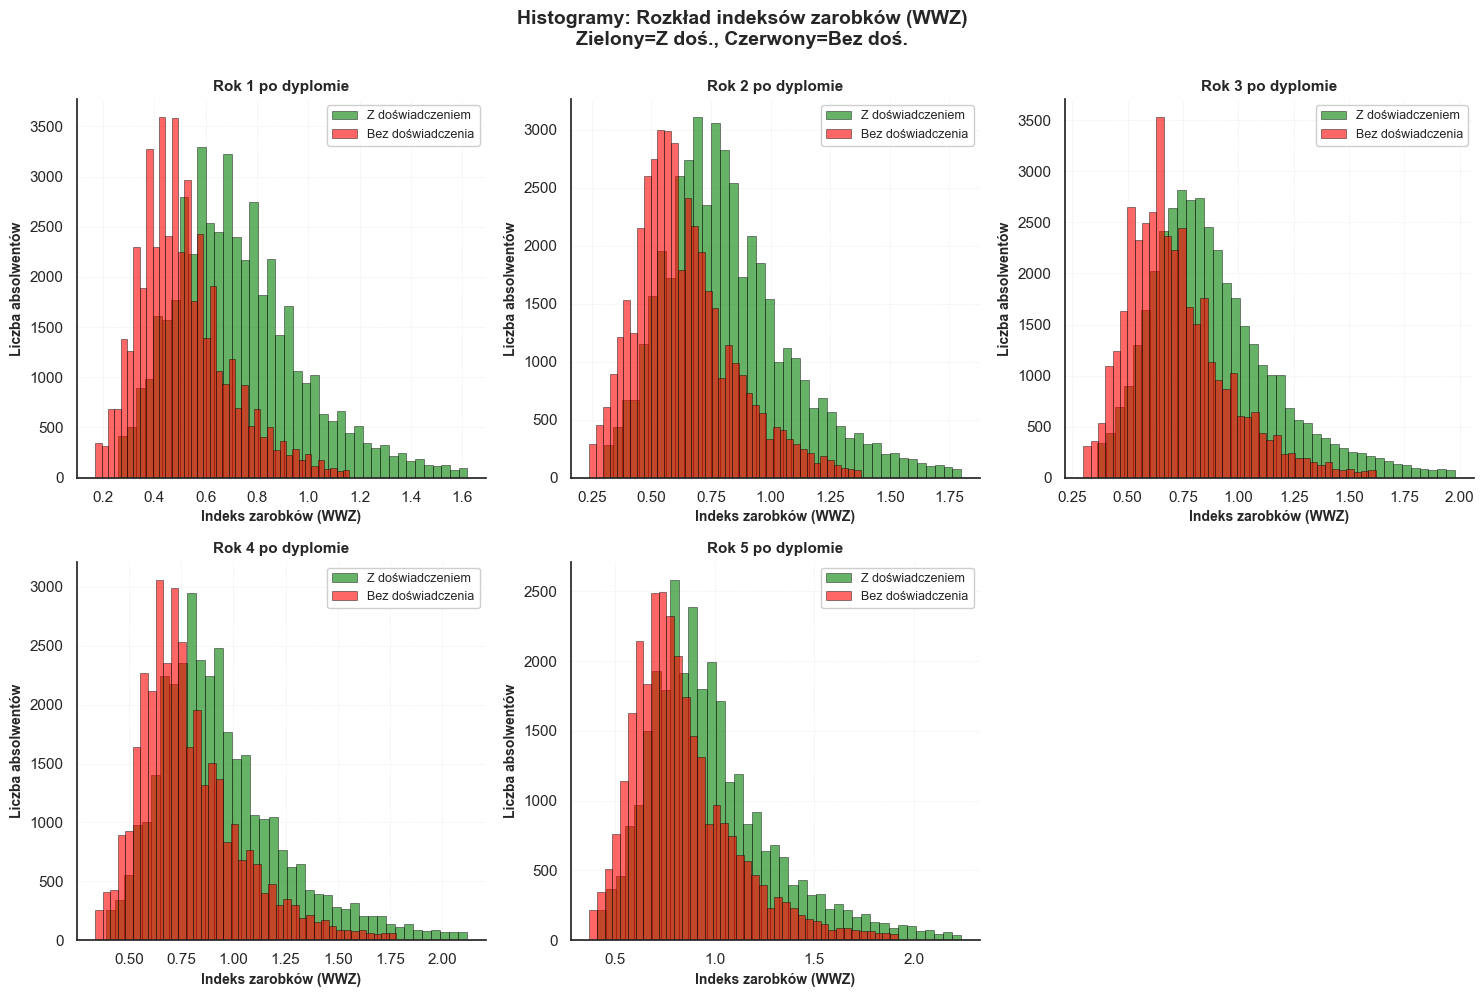

In [79]:
print("\n" + "="*80)
print("HISTOGRAMY: Porównanie rozkładu zarabków (indeks WWZ)")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() 

for i in range(1, 6):
    col_dosw = f'P_WWZ_DOSW_P{i}'
    col_ndosw = f'P_WWZ_NDOSW_P{i}'
    
    data_dosw = df[col_dosw].dropna()
    data_ndosw = df[col_ndosw].dropna()
    
    p1_dosw, p99_dosw = data_dosw.quantile([0.01, 0.99])
    p1_ndosw, p99_ndosw = data_ndosw.quantile([0.01, 0.99])
    
    data_dosw_clean = data_dosw[(data_dosw >= p1_dosw) & (data_dosw <= p99_dosw)]
    data_ndosw_clean = data_ndosw[(data_ndosw >= p1_ndosw) & (data_ndosw <= p99_ndosw)]
  
    ax = axes[i-1]  
  
    ax.hist(data_dosw_clean, bins=40, alpha=0.6, label='Z doświadczeniem',
            color='green', edgecolor='black', linewidth=0.5)
    
    ax.hist(data_ndosw_clean, bins=40, alpha=0.6, label='Bez doświadczenia',
            color='red', edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Indeks zarobków (WWZ)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Liczba absolwentów', fontsize=10, fontweight='bold')
    ax.set_title(f'Rok {i} po dyplomie', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    mean_dosw = data_dosw_clean.mean()
    mean_ndosw = data_ndosw_clean.mean()
    med_dosw = data_dosw_clean.median()
    med_ndosw = data_ndosw_clean.median()
    std_dosw = data_dosw_clean.std()
    std_ndosw = data_ndosw_clean.std()
    
    print(f"\nROK {i}:")
    print(f"  Osoby Z doświadczeniem (n={len(data_dosw_clean)}):")
    print(f"    - Średnia: {mean_dosw:.4f}")
    print(f"    - Mediana: {med_dosw:.4f}")
    print(f"    - Odch. stand. (zmienność): {std_dosw:.4f}")
    
    print(f"  Osoby BEZ doświadczenia (n={len(data_ndosw_clean)}):")
    print(f"    - Średnia: {mean_ndosw:.4f}")
    print(f"    - Mediana: {med_ndosw:.4f}")
    print(f"    - Odch. stand. (zmienność): {std_ndosw:.4f}")
    
    # Interpretacja
    print(f"  INTERPRETACJA:")
    if mean_dosw > mean_ndosw:
        diff = mean_dosw - mean_ndosw
        pct = (mean_dosw / mean_ndosw - 1) * 100
        print(f"      Osoby z doświadczeniem zarabiają średnio LEPIEJ o {diff:.4f} ({pct:+.2f}%)")
    else:
        diff = mean_ndosw - mean_dosw
        pct = (mean_ndosw / mean_dosw - 1) * 100
        print(f"      Osoby BEZ doświadczenia zarabiają średnio LEPIEJ o {diff:.4f} ({pct:+.2f}%)")
    
    # Zmienność (czy zarobki są jednolite, czy bardzo zróżnicowane?)
    if std_dosw < std_ndosw:
        print(f"    Zarobki osób z doś. są bardziej JEDNOLITE (mniejsza zmienności)")
    else:
        print(f"    Zarobki osób bez doś. są bardziej JEDNOLITE")

axes[-1].remove()

fig.suptitle('Histogramy: Rozkład indeksów zarobków (WWZ)\nZielony=Z doś., Czerwony=Bez doś.',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

plt.show()

### **PREDYKCJE**


Analiza TOP 5 kierunków

[1] Dziedzina nauk humanistycznych
────────────────────────────────────────────────────────────────────────────────
  Indeksy zarobków z lat 1-5: ['0.6624', '0.7356', '0.7881', '0.8344', '0.8695']

  HISTORIA (lata 1-5):
    Średni INDEKS zarabków: 0.7591
    (Tłumaczenie: jeśli 0.76, to ~24% poniżej średniej)

  PROGNOZA (rok 6):
    Średni INDEKS przewidywany: 0.8937
    Zmiana: +17.74%

  INTERPRETACJA:
    INDEKS ZAROBKÓW ROŚNIE - kierunek jest coraz bardziej atrakcyjny!

[2] Dziedzina nauk inżynieryjno-technicznych
────────────────────────────────────────────────────────────────────────────────
  Indeksy zarobków z lat 1-5: ['0.8805', '1.0104', '1.1155', '1.1925', '1.2477']

  HISTORIA (lata 1-5):
    Średni INDEKS zarabków: 1.0556
    (Tłumaczenie: jeśli 0.76, to ~24% poniżej średniej)

  PROGNOZA (rok 6):
    Średni INDEKS przewidywany: 1.2941
    Zmiana: +22.59%

  INTERPRETACJA:
    INDEKS ZAROBKÓW ROŚNIE - kierunek jest coraz bardziej atrakcyjny!

[3

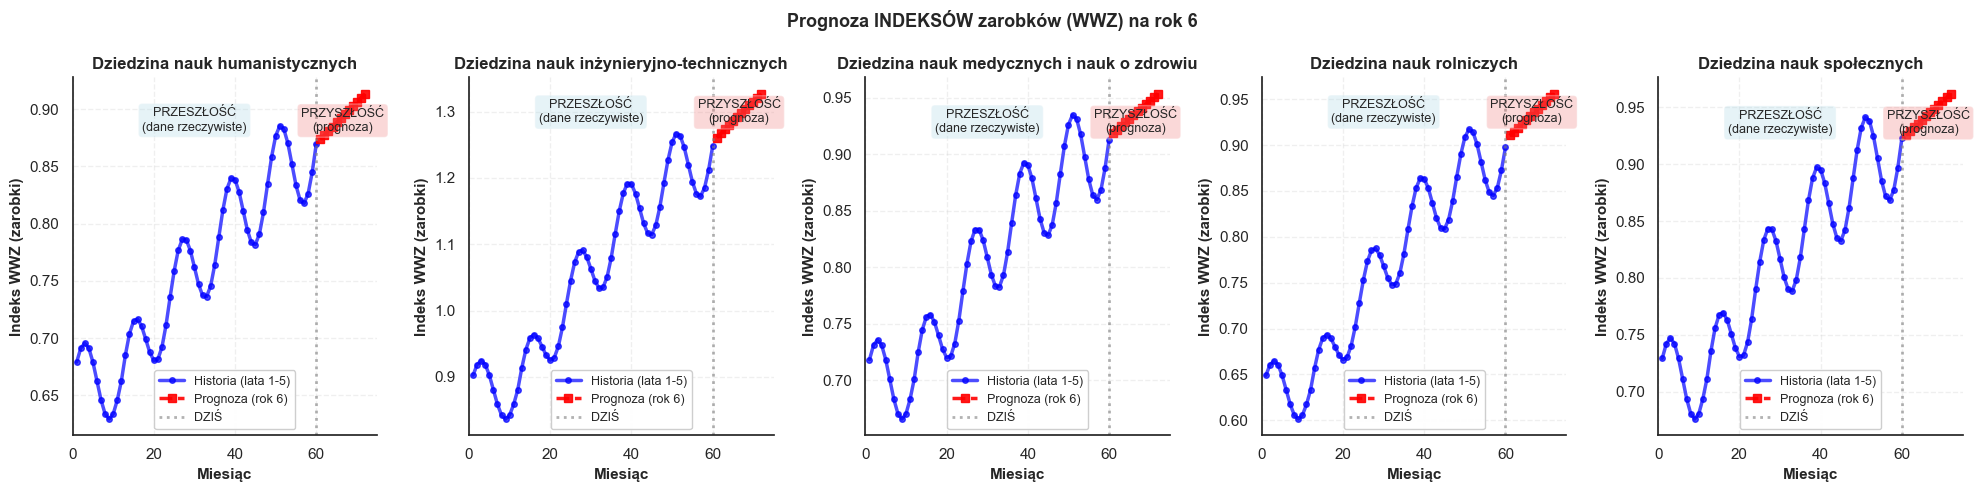

In [80]:
warnings.filterwarnings('ignore')

df_by_field = df.groupby('P_DZIEDZINA').agg({
    f'P_WWZ_DOSW_P{i}': 'mean' for i in range(1, 6)
}).reset_index()

# Timeline MIESIĘCZNY
months = np.arange(1, 61)
months_years = months / 12

print(f"\nAnaliza TOP 5 kierunków")
print("="*80)

predictions_summary = []

for field_idx, field_name in enumerate(df_by_field['P_DZIEDZINA'].head(5)):
    
    yearly_indices = [
        df_by_field.loc[df_by_field['P_DZIEDZINA'] == field_name, f'P_WWZ_DOSW_P{i}'].values[0]
        for i in range(1, 6)
    ]
    
    print(f"\n[{field_idx + 1}] {field_name}")
    print(f"{'─'*80}")
    print(f"  Indeksy zarobków z lat 1-5: {[f'{x:.4f}' for x in yearly_indices]}")
    
    # INTERPOLACJA: Zagęszczanie danych
    monthly_indices = np.interp(months_years, np.arange(1, 6), yearly_indices)
    
    # SEZONOWOŚĆ: Dodajemy naturalne wahania
    noise = 0.05 * monthly_indices * np.sin(2 * np.pi * months / 12)
    monthly_indices_noisy = monthly_indices + noise
    
    # TRENOWANIE MODELU: Polynomial Regression
    X = months.reshape(-1, 1)
    y = monthly_indices_noisy
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # PROGNOZA: Rok 6 (miesiące 61-72)
    future_months = np.arange(61, 73).reshape(-1, 1)
    future_X_poly = poly.transform(future_months)
    predictions = model.predict(future_X_poly)
    
    # ANALIZA WYNIKÓW
    avg_indeks_teraz = monthly_indices.mean()
    avg_prognoza = predictions.mean()
    trend_jednostkami = (predictions[-1] - predictions[0]) / len(predictions)
    zmiana_procent = ((avg_prognoza / avg_indeks_teraz - 1) * 100)
    
    predictions_summary.append({
        'Kierunek': field_name,
        'Indeks_teraz': avg_indeks_teraz,
        'Indeks_prognoza': avg_prognoza,
        'Zmiana_proc': zmiana_procent
    })
    
    # WYDRUK RAPORTÓW
    print(f"\n  HISTORIA (lata 1-5):")
    print(f"    Średni INDEKS zarabków: {avg_indeks_teraz:.4f}")
    print(f"    (Tłumaczenie: jeśli 0.76, to ~24% poniżej średniej)")
    
    print(f"\n  PROGNOZA (rok 6):")
    print(f"    Średni INDEKS przewidywany: {avg_prognoza:.4f}")
    print(f"    Zmiana: {zmiana_procent:+.2f}%")
    
    print(f"\n  INTERPRETACJA:")
    if zmiana_procent > 5:
        print(f"    INDEKS ZAROBKÓW ROŚNIE - kierunek jest coraz bardziej atrakcyjny!")
    elif zmiana_procent > -5:
        print(f"    INDEKS STAGNUJE - kierunek się stabilizuje")
    else:
        print(f"    INDEKS MALEJE - konkurencja lub zmiana rynku")

# WIZUALIZACJA

print("\n" + "="*80)
print("WIZUALIZACJA: Prognoza indeksów zarobków - TOP 5 kierunków")
print("="*80)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))  #   Zmień na (20, 5) dla 5 wykresów

for idx, field_name in enumerate(df_by_field['P_DZIEDZINA'].head(5)):  #   Zmień 3 na 5
    yearly_indices = [
        df_by_field.loc[df_by_field['P_DZIEDZINA'] == field_name, f'P_WWZ_DOSW_P{i}'].values[0]
        for i in range(1, 6)
    ]
    
    monthly_indices = np.interp(months_years, np.arange(1, 6), yearly_indices)
    noise = 0.05 * monthly_indices * np.sin(2 * np.pi * months / 12)
    monthly_indices_noisy = monthly_indices + noise
    
    X = months.reshape(-1, 1)
    y = monthly_indices_noisy
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    future_months = np.arange(61, 73).reshape(-1, 1)
    future_X_poly = poly.transform(future_months)
    predictions = model.predict(future_X_poly)
    
    ax = axes[idx]
    
    # HISTORIA: Linia niebieska
    ax.plot(months, monthly_indices_noisy, 'o-', label='Historia (lata 1-5)',
            alpha=0.7, linewidth=2.5, markersize=4, color='blue')
    
    # PROGNOZA: Linia czerwona
    ax.plot(np.arange(61, 73), predictions, 's--', label='Prognoza (rok 6)',
            alpha=0.9, linewidth=2.5, markersize=6, color='red')
    
    # GRANICA: Szara linia
    ax.axvline(x=60, color='gray', linestyle=':', alpha=0.6, linewidth=2, label='DZIŚ')
    
    ax.set_xlabel('Miesiąc', fontsize=11, fontweight='bold')
    ax.set_ylabel('Indeks WWZ (zarobki)', fontsize=11, fontweight='bold')
    ax.set_title(f'{field_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9, framealpha=0.95)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_xlim(0, 75)
    
    ax.text(30, ax.get_ylim()[1]*0.95, 'PRZESZŁOŚĆ\n(dane rzeczywiste)', 
            fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax.text(66.5, ax.get_ylim()[1]*0.95, 'PRZYSZŁOŚĆ\n(prognoza)', 
            fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

fig.suptitle('Prognoza INDEKSÓW zarobków (WWZ) na rok 6',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### **PRZEDZIAŁY UFNOŚCI (95%)**

In [81]:
print("\n" + "─"*80)
print("PRZEDZIAŁY UFNOŚCI (95%)")
print("─"*80)

from scipy import stats as sp_stats

for i in range(1, 6):
    col_dosw = f'P_WWZ_DOSW_P{i}'
    col_ndosw = f'P_WWZ_NDOSW_P{i}'
    
    group_dosw = df[col_dosw].dropna()
    group_ndosw = df[col_ndosw].dropna()
    
    # Przedział ufności metodą t-Studenta
    ci_dosw = sp_stats.t.interval(
        0.95, 
        len(group_dosw)-1, 
        loc=group_dosw.mean(), 
        scale=group_dosw.sem()
    )
    
    ci_ndosw = sp_stats.t.interval(
        0.95,
        len(group_ndosw)-1,
        loc=group_ndosw.mean(),
        scale=group_ndosw.sem()
    )
    
    print(f"Rok {i}:")
    print(f"  Z doświadczeniem:")
    print(f"    Średnia: {group_dosw.mean():.4f}")
    print(f"    95% CI: [{ci_dosw[0]:.4f}, {ci_dosw[1]:.4f}]")
    print(f"  Bez doświadczenia:")
    print(f"    Średnia: {group_ndosw.mean():.4f}")
    print(f"    95% CI: [{ci_ndosw[0]:.4f}, {ci_ndosw[1]:.4f}]")
    



────────────────────────────────────────────────────────────────────────────────
PRZEDZIAŁY UFNOŚCI (95%)
────────────────────────────────────────────────────────────────────────────────
Rok 1:
  Z doświadczeniem:
    Średnia: 0.7351
    95% CI: [0.7327, 0.7376]
  Bez doświadczenia:
    Średnia: 0.5204
    95% CI: [0.5168, 0.5240]
Rok 2:
  Z doświadczeniem:
    Średnia: 0.8274
    95% CI: [0.8246, 0.8302]
  Bez doświadczenia:
    Średnia: 0.6415
    95% CI: [0.6393, 0.6436]
Rok 3:
  Z doświadczeniem:
    Średnia: 0.8942
    95% CI: [0.8911, 0.8973]
  Bez doświadczenia:
    Średnia: 0.7286
    95% CI: [0.7259, 0.7313]
Rok 4:
  Z doświadczeniem:
    Średnia: 0.9484
    95% CI: [0.9449, 0.9519]
  Bez doświadczenia:
    Średnia: 0.7962
    95% CI: [0.7933, 0.7991]
Rok 5:
  Z doświadczeniem:
    Średnia: 0.9888
    95% CI: [0.9848, 0.9928]
  Bez doświadczenia:
    Średnia: 0.8455
    95% CI: [0.8421, 0.8488]


### **WIELKOŚĆ EFEKTU (Cohen's d)**

In [82]:

print("\nCohen's d: jak bardzo się grupy różnią (niezależnie od liczby obserwacji)")
print("|d| < 0.2 = efekt ZNIKOMY")
print("|d| 0.2-0.5 = efekt MAŁY")
print("|d| 0.5-0.8 = efekt ŚREDNI")
print("|d| > 0.8 = efekt DUŻY\n")

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

for i in range(1, 6):
    col_dosw = f'P_WWZ_DOSW_P{i}'
    col_ndosw = f'P_WWZ_NDOSW_P{i}'
    
    group_dosw = df[col_dosw].dropna()
    group_ndosw = df[col_ndosw].dropna()
    
    d = cohens_d(group_dosw, group_ndosw)
    
    print(f"Rok {i}: d = {d:+.4f}  ", end="")
    
    if abs(d) < 0.2:
        print("(efekt ZNIKOMY)")
    elif abs(d) < 0.5:
        print("(efekt MAŁY)")
    elif abs(d) < 0.8:
        print("(efekt ŚREDNI)")
    else:
        print("(efekt DUŻY)")


Cohen's d: jak bardzo się grupy różnią (niezależnie od liczby obserwacji)
|d| < 0.2 = efekt ZNIKOMY
|d| 0.2-0.5 = efekt MAŁY
|d| 0.5-0.8 = efekt ŚREDNI
|d| > 0.8 = efekt DUŻY

Rok 1: d = +0.6299  (efekt ŚREDNI)
Rok 2: d = +0.6932  (efekt ŚREDNI)
Rok 3: d = +0.5522  (efekt ŚREDNI)
Rok 4: d = +0.4912  (efekt MAŁY)
Rok 5: d = +0.4348  (efekt MAŁY)


In [83]:
warnings.filterwarnings('ignore')

def load_data():
    path = Path('./data/graduates-major-data.csv')
    configs = [
        {'encoding': 'utf-8', 'sep': ';'},
        {'encoding': 'cp1250', 'sep': ';'},
        {'encoding': 'utf-8', 'sep': ','},
        {'encoding': 'cp1250', 'sep': ','}
    ]
    
    for config in configs:
        try:
            temp_df = pd.read_csv(
                path, 
                encoding=config['encoding'], 
                sep=config['sep'], 
                decimal=',', 
                on_bad_lines='skip', 
                low_memory=False
            )
            if temp_df.shape[1] > 1:
                temp_df.columns = [c.strip().replace('"', '') for c in temp_df.columns]
                return temp_df
        except:
            continue
    return None

df_orig = load_data()

Model RF badający wpływ zmiennych na IS po 5 latach.

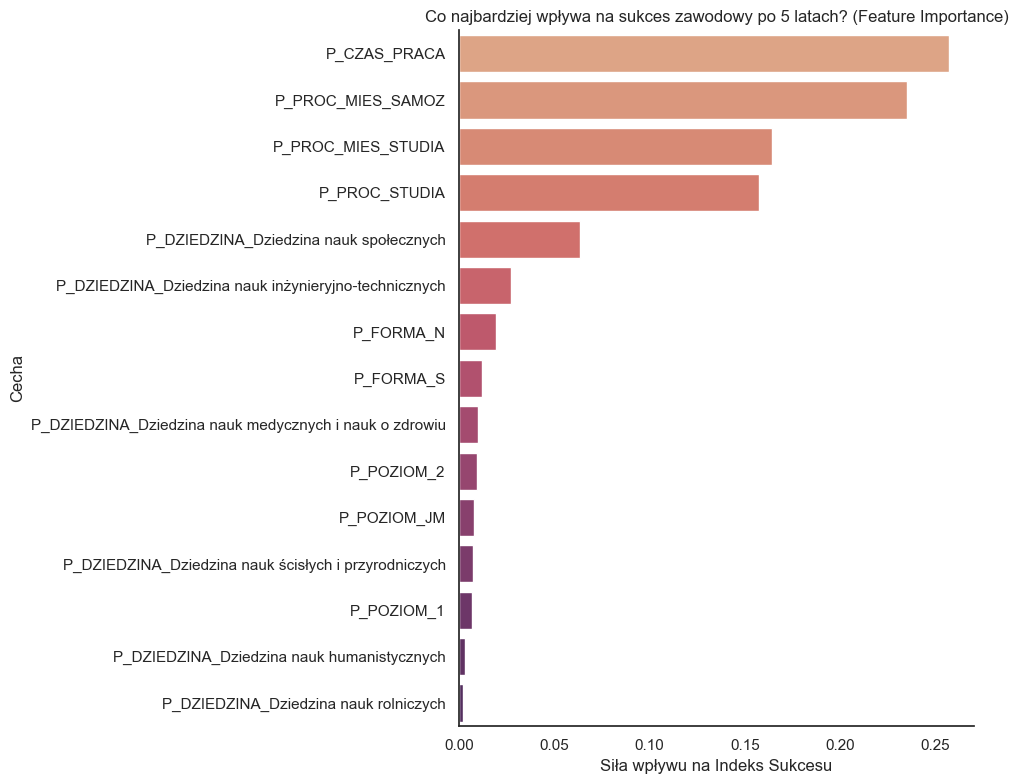

Model zakończył analizę.
                                                Cecha   Waznosc
2                                        P_CZAS_PRACA  0.257238
3                                   P_PROC_MIES_SAMOZ  0.234711
1                                  P_PROC_MIES_STUDIA  0.164006
0                                       P_PROC_STUDIA  0.157224
8              P_DZIEDZINA_Dziedzina nauk społecznych  0.063441
5   P_DZIEDZINA_Dziedzina nauk inżynieryjno-techni...  0.027437
15                                          P_FORMA_N  0.019711
16                                          P_FORMA_S  0.011894
6   P_DZIEDZINA_Dziedzina nauk medycznych i nauk o...  0.010006
13                                         P_POZIOM_2  0.009341


In [84]:
# 1. Lista zweryfikowanych cech (Features) istniejących w pliku
features = [
    'P_DZIEDZINA',         # Dziedzina nauki
    'P_POZIOM',            # Poziom studiów (I, II, jednolite)
    'P_FORMA',             # Forma (stacjonarne / niestacjonarne)
    'P_PROC_STUDIA',       # % osób pracujących na studiach
    'P_PROC_MIES_STUDIA',  # Intensywność pracy na studiach (% miesięcy)
    'P_CZAS_PRACA',        # Czas szukania pierwszej pracy
    'P_CZY_PRACA_MUNDUR',  # Czy praca w służbach mundurowych
    'P_PROC_MIES_SAMOZ'    # Intensywność samozatrudnienia
]

# 2. Przygotowanie danych i celu (Target)
# Obliczamy Indeks Sukcesu dla 5. roku (P5) dla grupy z doświadczeniem
df_orig['IS_TARGET'] = pd.to_numeric(df_orig['P_WWZ_DOSW_P5'], errors='coerce') / \
                  pd.to_numeric(df_orig['P_WWB_DOSW_P5'] + epsilon, errors='coerce')

# Wybieramy dane i usuwamy wiersze, gdzie nie udało się obliczyć indeksu
df_model = df_orig[features + ['IS_TARGET']].dropna(subset=['IS_TARGET'])

X_raw = df_model[features]
y = df_model['IS_TARGET']

# 3. Kodowanie zmiennych tekstowych (One-Hot Encoding)
X = pd.get_dummies(X_raw, columns=['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_CZY_PRACA_MUNDUR'])

# Uzupełnienie ewentualnych braków w cechach średnią
X = X.fillna(X.median())

# 4. Trenowanie modelu
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 5. Ranking ważności
importance = pd.DataFrame({
    'Cecha': X.columns,
    'Waznosc': model.feature_importances_
}).sort_values('Waznosc', ascending=False)

# 6. Wizualizacja
plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(15), x='Waznosc', y='Cecha', palette='flare')
plt.title('Co najbardziej wpływa na sukces zawodowy po 5 latach? (Feature Importance)')
plt.xlabel('Siła wpływu na Indeks Sukcesu')
plt.tight_layout()
plt.show()

print("Model zakończył analizę.")
print(importance.head(10))

Najlepsza iteracja modelu OLS z badaniem interakcji zmiennych – R^2 na poziomie 20%. Można spróbować pobawić się ze zmiennymi.

In [85]:
# 1. Przygotowanie danych
# Dodajemy P_N_SEMESTR (liczba) i P_WOJ (kategoria)
numerical_cols = ['P_PROC_MIES_STUDIA', 'P_CZAS_PRACA', 'P_PROC_MIES_SAMOZ', 
                  'P_PROC_MIES_BEZR', 'P_N_SEMESTR']
categorical_cols = ['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_WOJ']  

df_v4 = df_orig.copy()

# Konwersja WOJ na string, aby get_dummies zadziałało poprawnie
df_v4['P_WOJ'] = df_v4['P_WOJ'].astype(str)

for col in numerical_cols:
    df_v4[col] = pd.to_numeric(df_v4[col], errors='coerce')

wwz = pd.to_numeric(df_v4['P_WWZ_DOSW_P5'], errors='coerce')
wwb = pd.to_numeric(df_v4['P_WWB_DOSW_P5'], errors='coerce') + epsilon
df_v4['IS_TARGET'] = np.log(wwz / wwb)  # Log ratio

df_clean = df_v4[categorical_cols + numerical_cols + ['IS_TARGET']].dropna()

# 2. Encoding i Interakcje
X = pd.get_dummies(df_clean[categorical_cols + numerical_cols], columns=categorical_cols, drop_first=True)

# Dodajemy sprawdzoną interakcję Dziedzina x Praca
for col in [c for c in X.columns if 'P_DZIEDZINA' in c]:
    X[f'INT_{col[-10:]}_x_Praca'] = X[col] * X['P_PROC_MIES_STUDIA']

# 3. Model OLS
X_ols = sm.add_constant(X.astype(float))
y_ols = df_clean['IS_TARGET'].astype(float)

model_v4 = sm.OLS(y_ols, X_ols).fit()

# 4. Analiza wyników
print(f"Model v4 (Semestry + Województwa) R-squared: {model_v4.rsquared:.4f}")
print("-" * 50)
res_v4 = pd.DataFrame({'Coef': model_v4.params, 'P': model_v4.pvalues})
sig_v4 = res_v4[res_v4['P'] < 0.05].sort_values('Coef', ascending=False)

print("Najsilniejsze istotne zmienne w nowym modelu:")
print(sig_v4.head(15))

Model v4 (Semestry + Województwa) R-squared: 0.2020
--------------------------------------------------
Najsilniejsze istotne zmienne w nowym modelu:
                                                        Coef              P
const                                               3.552080   1.383779e-73
P_FORMA_S                                           0.847976  4.679634e-120
P_WOJ_6.0                                           0.453606   1.248085e-09
P_DZIEDZINA_Dziedzina nauk ścisłych i przyrodni...  0.410308   1.015208e-04
P_POZIOM_JM                                         0.391185   1.156465e-03
P_WOJ_18.0                                          0.352466   1.469635e-05
P_DZIEDZINA_Dziedzina nauk inżynieryjno-technic...  0.280194   3.718516e-04
P_WOJ_26.0                                          0.259639   7.337349e-03
P_WOJ_28.0                                          0.232446   1.253016e-02
P_WOJ_20.0                                          0.214847   1.632525e-02
P_PROC_MIES_SAM

Obliczanie reszt modelu. Nie jest jakiś świetny, ale pozwala na dalszą analizę.

In [86]:
# 1. Obliczamy przewidywane wartości i błędy
df_clean['PREDICTED_IS'] = model_v4.predict(X_ols)
df_clean['RESIDUAL'] = df_clean['IS_TARGET'] - df_clean['PREDICTED_IS']

# 2. Standaryzacja reszt (żeby łatwiej ocenić skalę błędu)
df_clean['RESIDUAL_STD'] = (df_clean['RESIDUAL'] - df_clean['RESIDUAL'].mean()) / df_clean['RESIDUAL'].std()

# 3. Wyciągamy TOP 10 kierunków "ponad stan" (pozytywne zaskoczenia)
# Załóżmy, że masz kolumnę 'P_NAZWA_KIERUNKU' lub podobną
top_outperformers = df_clean.sort_values('RESIDUAL', ascending=False).head(10)

# 4. Wyciągamy TOP 10 kierunków "poniżej oczekiwań"
top_underperformers = df_clean.sort_values('RESIDUAL', ascending=True).head(10)

print("KIERUNKI 'PONAD STAN' (Największe pozytywne reszty):")
# Wyświetlamy najważniejsze informacje dla tych rekordów
cols_to_show = ['P_DZIEDZINA', 'IS_TARGET', 'PREDICTED_IS', 'RESIDUAL']
# Jeśli masz nazwę kierunku/uczelni w df, dodaj ją tutaj:
# cols_to_show = ['P_NAZWA_KIERUNKU', 'P_NAZWA_UCZELNI'] + cols_to_show

print(top_outperformers[cols_to_show])

print("KIERUNKI 'PONIŻEJ OCZEKIWAŃ':")
print(top_underperformers[cols_to_show])

KIERUNKI 'PONAD STAN' (Największe pozytywne reszty):
                                    P_DZIEDZINA  IS_TARGET  PREDICTED_IS  \
27182                Dziedzina nauk społecznych   5.105945     -2.170602   
26574                Dziedzina nauk społecznych   4.043051     -2.713021   
7061   Dziedzina nauk inżynieryjno-technicznych   5.075174     -0.932188   
7528   Dziedzina nauk inżynieryjno-technicznych   4.828314     -1.066940   
32485                          Dziedzina sztuki   4.406719     -1.361090   
13918                Dziedzina nauk społecznych   4.584967     -1.173388   
22791  Dziedzina nauk ścisłych i przyrodniczych   4.890349     -0.765899   
20264            Dziedzina nauk humanistycznych   4.430817     -1.198452   
35325  Dziedzina nauk inżynieryjno-technicznych   4.317488     -1.286461   
13429                Dziedzina nauk społecznych   4.488636     -1.001772   

       RESIDUAL  
27182  7.276548  
26574  6.756073  
7061   6.007362  
7528   5.895254  
32485  5.767809  
13

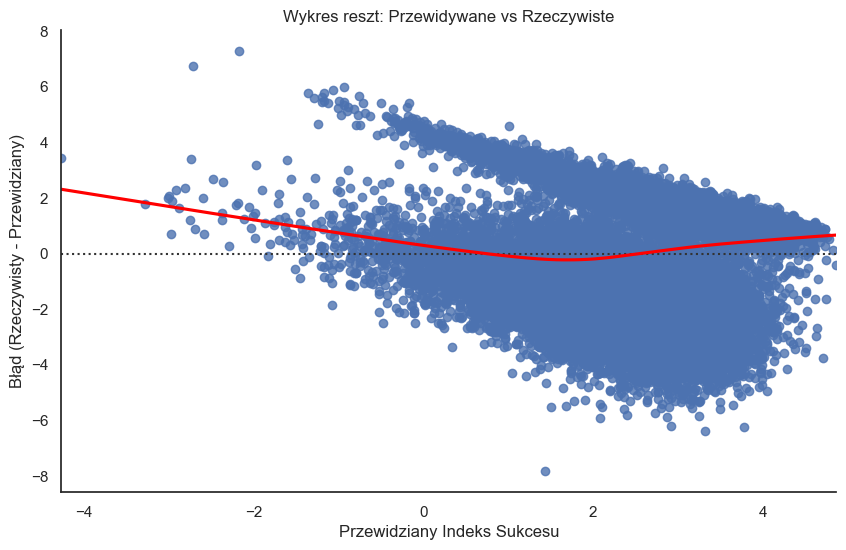

In [87]:
plt.figure(figsize=(10, 6))
sns.residplot(x=df_clean['PREDICTED_IS'], y=df_clean['IS_TARGET'], lowess=True, line_kws={'color': 'red'})
plt.title('Wykres reszt: Przewidywane vs Rzeczywiste')
plt.xlabel('Przewidziany Indeks Sukcesu')
plt.ylabel('Błąd (Rzeczywisty - Przewidziany)')
plt.show()

Ranking uzcelni na podstawie IS.

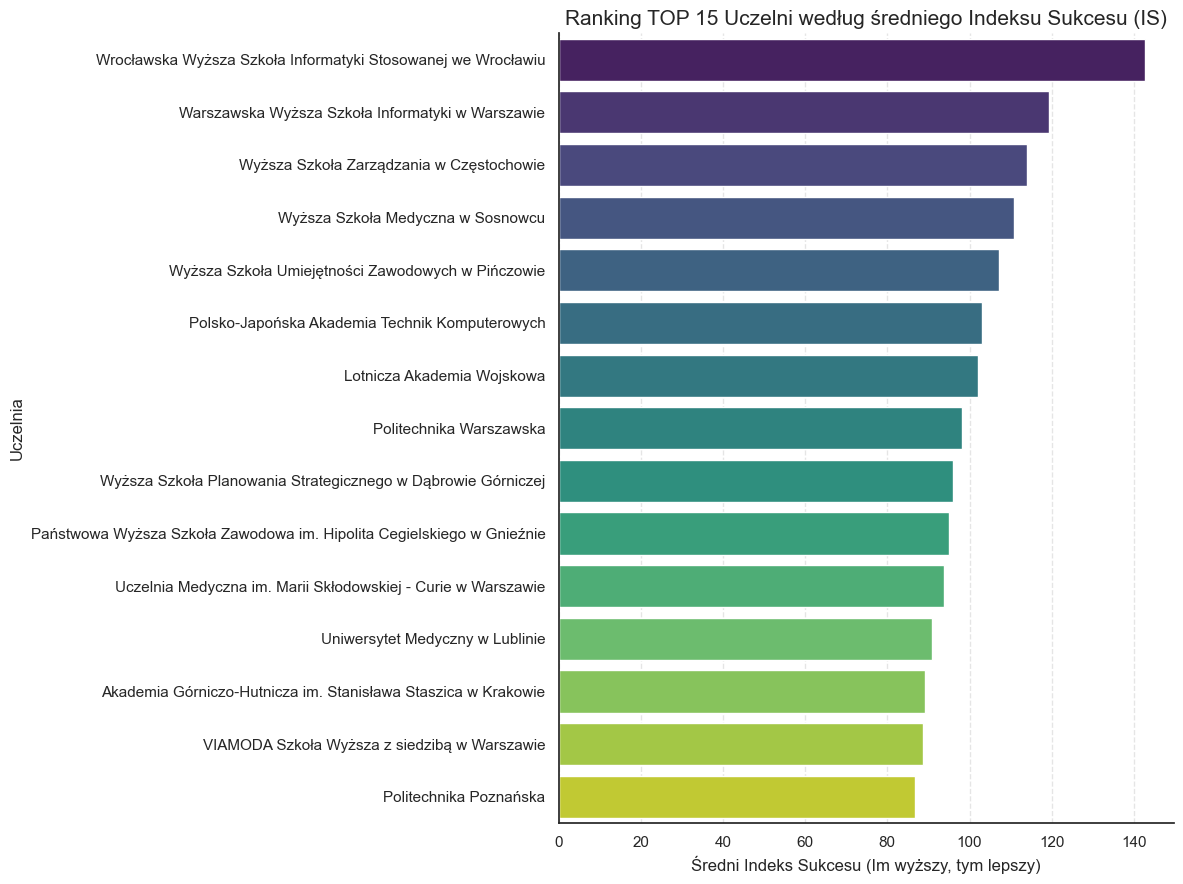

Najlepsze uczelnie pod kątem ekonomicznego sukcesu absolwentów:
                                                     Sredni_IS  \
P_NAZWA_UCZELNI                                                  
Wrocławska Wyższa Szkoła Informatyki Stosowanej...  142.623188   
Warszawska Wyższa Szkoła Informatyki w Warszawie    119.251990   
Wyższa Szkoła Zarządzania w Częstochowie            113.875000   
Wyższa Szkoła Medyczna w Sosnowcu                   110.855219   
Wyższa Szkoła Umiejętności Zawodowych w Pińczowie   107.066667   
Polsko-Japońska Akademia Technik Komputerowych      103.048519   
Lotnicza Akademia Wojskowa                          101.944378   
Politechnika Warszawska                              98.179862   
Wyższa Szkoła Planowania Strategicznego w Dąbro...   95.999729   
Państwowa Wyższa Szkoła Zawodowa im. Hipolita C...   94.906929   
Uczelnia Medyczna im. Marii Skłodowskiej - Curi...   93.821601   
Uniwersytet Medyczny w Lublinie                      90.869149   
Akademia Gór

In [88]:
# 1. Definiujemy listy cech, dodając nazwę uczelni do zestawu danych
categorical_features = ['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_WOJ']
numerical_features = [
    'P_PROC_MIES_STUDIA', 
    'P_CZAS_PRACA', 
    'P_PROC_MIES_SAMOZ',
    'P_PROC_MIES_BEZR',
    'P_N_SEMESTR'
]
uczelnia_col = 'P_NAZWA_UCZELNI'

# 2. Przygotowanie danych z zachowaniem nazwy uczelni
df_ana = df_orig.copy()

# Konwersja numeryczna
for col in numerical_features:
    df_ana[col] = pd.to_numeric(df_ana[col], errors='coerce')

# Obliczamy Indeks Sukcesu (IS)
df_ana['IS_TARGET'] = pd.to_numeric(df_ana['P_WWZ_DOSW_P5'], errors='coerce') / \
                       pd.to_numeric(df_ana['P_WWB_DOSW_P5'] + epsilon, errors='coerce') 

# KLUCZOWY MOMENT: Wybieramy kolumny do analizy, w tym P_NAZWA_UCZELNI
cols_to_keep = categorical_features + numerical_features + ['IS_TARGET', uczelnia_col]
df_final_ana = df_ana[cols_to_keep].dropna()

# 3. Agregacja danych po uczelniach
ranking_uczelni = df_final_ana.groupby(uczelnia_col).agg({
    'IS_TARGET': ['mean', 'std', 'count'],
    'P_PROC_MIES_STUDIA': 'mean',
    'P_PROC_MIES_SAMOZ': 'mean'
})

# Zmiana nazw kolumn na płaskie
ranking_uczelni.columns = ['Sredni_IS', 'Odchylenie_IS', 'Liczba_Kierunkow', 'Srednia_Praca_Studia', 'Srednia_Samozatrudnienie']

# 4. Filtrowanie - minimum 5 kierunków dla wiarygodności
ranking_filtered = ranking_uczelni[ranking_uczelni['Liczba_Kierunkow'] >= 5].sort_values('Sredni_IS', ascending=False)

# 5. Wizualizacja TOP 15
plt.figure(figsize=(12, 9))
top_15 = ranking_filtered.head(15)

sns.barplot(
    x=top_15['Sredni_IS'], 
    y=top_15.index, 
    hue=top_15.index, 
    palette='viridis', 
    legend=False
)

plt.title('Ranking TOP 15 Uczelni według średniego Indeksu Sukcesu (IS)', fontsize=15)
plt.xlabel('Średni Indeks Sukcesu (Im wyższy, tym lepszy)', fontsize=12)
plt.ylabel('Uczelnia', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Wyświetlenie tabeli wynikowej
print("Najlepsze uczelnie pod kątem ekonomicznego sukcesu absolwentów:")
print(ranking_filtered[['Sredni_IS', 'Liczba_Kierunkow', 'Srednia_Praca_Studia']].head(15))

In [89]:
# 1. Obliczenie średniego Względnego Wskaźnika Zarobków (WWZ) ze wszystkich miesięcy
# Wyciągamy kolumny P_WWZ_MIES_1, P_WWZ_MIES_2 itd.
wwz_cols = [c for c in df_orig.columns if re.match(r'^P_WWZ_MIES_\d+$', c)]
df_orig['Sredni_WWZ'] = df_orig[wwz_cols].mean(axis=1)

# 2. Stworzenie pomocniczego zbioru do analizy (usuwamy braki tylko w zmiennych, które badamy)
# Odrzucamy skrajne wartości odstające (np. WWZ > 3, czyli 3x średnia w powiecie) dla czytelności wykresów
df_analiza = df_orig.dropna(subset=['Sredni_WWZ', 'P_DZIEDZINA', 'P_FORMA']).copy()
df_analiza = df_analiza[df_analiza['Sredni_WWZ'] < 3.0]

print(f"Gotowe do analizy. Liczba obserwacji: {len(df_analiza)}")
print("Dostępne dziedziny:", df_analiza['P_DZIEDZINA'].unique())

Gotowe do analizy. Liczba obserwacji: 69220
Dostępne dziedziny: ['Dziedzina nauk humanistycznych' 'Dziedzina nauk społecznych'
 'Dziedzina sztuki' 'Dziedzina nauk medycznych i nauk o zdrowiu'
 'Dziedzina nauk inżynieryjno-technicznych'
 'Dziedzina nauk ścisłych i przyrodniczych' 'Dziedzina nauk rolniczych'
 'Dziedzina nauk teologicznych']


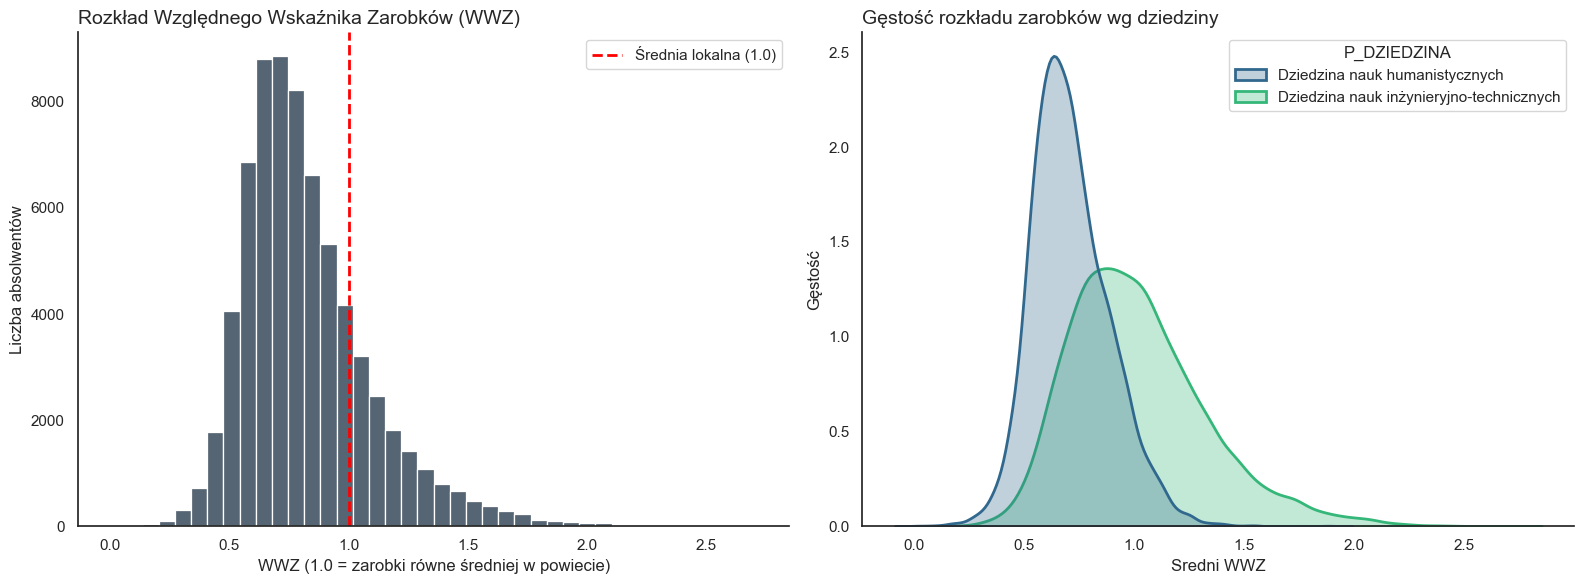

In [90]:
# Ustawienie stylu (czyste tło, wyraźne linie)
sns.set_theme(style="white", context="notebook")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# A. Histogram Zarobków (Sredni_WWZ)
sns.histplot(df_analiza['Sredni_WWZ'], bins=40, kde=False, color="#2c3e50", edgecolor="white", alpha=0.8, ax=ax[0])
ax[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Średnia lokalna (1.0)')
ax[0].set_title('Rozkład Względnego Wskaźnika Zarobków (WWZ)', fontsize=14, loc='left')
ax[0].set_xlabel('WWZ (1.0 = zarobki równe średniej w powiecie)')
ax[0].set_ylabel('Liczba absolwentów')
ax[0].legend()

# B. Wykres Gęstości (KDE) dla dwóch wybranych dziedzin
# Porównujemy Humanistów vs Inżynierów (dostosuj nazwy jeśli w danych są inne)
grupy_porownawcze = ['Dziedzina nauk humanistycznych', 'Dziedzina nauk inżynieryjno-technicznych']
subset = df_analiza[df_analiza['P_DZIEDZINA'].isin(grupy_porownawcze)]

sns.kdeplot(data=subset, x='Sredni_WWZ', hue='P_DZIEDZINA', fill=True, common_norm=False, palette='viridis', alpha=0.3, linewidth=2, ax=ax[1])
ax[1].set_title('Gęstość rozkładu zarobków wg dziedziny', fontsize=14, loc='left')
ax[1].set_xlabel('Sredni WWZ')
ax[1].set_ylabel('Gęstość')

plt.tight_layout()
plt.show()

1. Sprawdzamy strukturę sukcesu finansowego całej populacji badanych absolwentów. Większość ludzi zarabia "średnio" chociaż precyzyjniej jest powiedzieć, że poniżej średniej, a nieliczna grupa zarabia "bardzo dużo" (ciągnąc średnią w górę). Histogram pokazuje, jak duża jest ta grupa krezusów.

2. Sredni_WWZ --> Jest to stosunek zarobków absolwenta do średnich zarobków w powiecie, w którym mieszka. Widać, że rozkład dla inżynieryjno-technicznych jest bardziej "normalny" niż dla nauk humanistycznych

In [91]:
# Wybieramy grupy do porównania
grupa_hum = df_analiza[df_analiza['P_DZIEDZINA'] == 'Dziedzina nauk humanistycznych']['Sredni_WWZ']
grupa_tech = df_analiza[df_analiza['P_DZIEDZINA'] == 'Dziedzina nauk inżynieryjno-technicznych']['Sredni_WWZ']

# 1. Test Manna-Whitneya (bo rozkłady nie są normalne)
u_stat, p_val = stats.mannwhitneyu(grupa_hum, grupa_tech, alternative='two-sided')

# 2. Bootstrapping dla różnicy średnich (weryfikacja wyniku)
n_boot = 2000
diffs = []
for _ in range(n_boot):
    s_h = grupa_hum.sample(frac=1, replace=True).mean()
    s_t = grupa_tech.sample(frac=1, replace=True).mean()
    diffs.append(s_t - s_h) # Różnica: Techniczne - Humanistyczne

ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

# 3. Analiza kategorialna: Dziedzina vs Forma studiów (Stacjonarne/Niestacjonarne)
# Sprawdzamy czy wybór dziedziny zależy od formy studiów
tabela_kontyngencji = pd.crosstab(subset['P_DZIEDZINA'], subset['P_FORMA'])
chi2, p_chi2, dof, ex = stats.chi2_contingency(tabela_kontyngencji)
# V-Cramera
n = tabela_kontyngencji.sum().sum()
v_cramer = np.sqrt(chi2 / (n * (min(tabela_kontyngencji.shape) - 1)))

print(f"--- WYNIKI ---")
print(f"Test Manna-Whitneya (p-value): {p_val:.4e} {'(Istotna różnica)' if p_val < 0.05 else '(Brak różnicy)'}")
print(f"Bootstrap 95% CI dla różnicy średnich (Tech - Hum): [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"Test Chi-Kwadrat (zależność Dziedzina <-> Forma): p={p_chi2:.4e}")
print(f"Siła związku (V-Cramera): {v_cramer:.3f}")

--- WYNIKI ---
Test Manna-Whitneya (p-value): 0.0000e+00 (Istotna różnica)
Bootstrap 95% CI dla różnicy średnich (Tech - Hum): [0.299, 0.312]
Test Chi-Kwadrat (zależność Dziedzina <-> Forma): p=1.0797e-86
Siła związku (V-Cramera): 0.129


**Interpretacja**

Mann-Whitney (Porównanie zarobków)
- Wykorzystano test Manna-Whitneya (nazwa grupy zobowiązuje), bo zarobki rzadko mają rozkład normalny (gdyby tak było to t-Studenta miały sens): wynik 0 absolutnie wręcz - Szansa na to, że różnica w zarobkach między tymi grupami jest dziełem przypadku, jest praktycznie żadna.
- Odrzucamy hipotezę zerową. Istnieje istotna statystycznie różnica w zarobkach. Inżynierowie i humaniści zarabiają inaczej

Bootstrap (Szacowanie różnicy)
- Różnica istnieje, ale ile ona wynosi? Tu na pomoc przychodzi bootstrap [0.299, 0.312] (dla różnicy: Techniczne minus Humanistyczne).
- Przedział nie zawiera zera (jest w całości dodatni), co potwierdza przewagę grupy technicznej. 
- Wartości ok. 0.3 oznaczają, że absolwenci nauk inżynieryjno-technicznych zarabiają średnio o ok. 0.3 średniej krajowej więcej niż humaniści.

test Chi-kwadrat (Zależność kategorialna)
- Czy wybór dziedziny (Humanistyczna/Techniczna) ma związek z trybem studiowania (Stacjonarne/Niestacjonarne).
- p=1.0797e-86 -> Te dwie cechy są ze sobą powiązane. Nie jest tak, że rozkład studentów stacjonarnych jest taki sam na politechnikach i na wydziałach humanistycznych. Istnieje zależność.

V-Cramera (Siła związku)
- p-value z testu Chi-Kwadrat informuje nas, że zależność istnieje, teraz kwestia w jakim stopniu: V-Cramer mówi nam, czy ta zależność jest silna (skala 0 do 1).
- 0.129 --> oznacza związek słaby, w praktyce rodzaj studiów (Hum/Tech) tylko w niewielkim stopniu determinuje to, czy ktoś studiuje dziennie czy zaocznie. Inne czynniki (np. zamożność, miasto) mogą być ważniejsze. (dalsza analiza mogłaby tu rzucić więcej światła)

In [92]:
# Cel: Przewidzieć WWZ na podstawie:
# 1. Pracy podczas studiów (P_PROC_MIES_STUDIA - % miesięcy przepracowanych)
# 2. Dziedziny (zmienna kategorialna)

# Przygotowanie danych (One-Hot Encoding dla dziedziny)
# Używamy drop_first=True, aby uniknąć pułapki współliniowości
X = pd.get_dummies(df_analiza[['P_PROC_MIES_STUDIA', 'P_DZIEDZINA']], columns=['P_DZIEDZINA'], drop_first=True)

# Dodajemy stałą (intercept)
X = sm.add_constant(X)
# replace inf with NaN, then drop missing
data = pd.concat([df_analiza['Sredni_WWZ'], X], axis=1)
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y_clean = data['Sredni_WWZ']
X_clean = data.drop(columns=['Sredni_WWZ'])

model = sm.OLS(y_clean, X_clean.astype(float)).fit()
print(model.summary())

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Sredni_WWZ   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     2800.
Date:                Sat, 17 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:57:58   Log-Likelihood:                 2074.2
No. Observations:               62290   AIC:                            -4130.
Df Residuals:                   62281   BIC:                            -4049.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

**Interpretacja**

- R-squared: 0.265
model wyjaśnia 26.5% zmienności zarobków. Oznacza to, że dziedzina studiów i praca w ich trakcie odpowiadają za ponad 1/4 zmienności zmiennej objaśnianej (sukcesu finansowego).

- Wyraz wolny (const)
coef = 0.8345 || P>|t| = 0.000: "Czysty" Humanista bez pracy na studiach zarabia średnio 83% średniej w swoim powiecie.

- P_PROC_MIES_STUDIA
coef = -0.0044 --> Każdy dodatkowy punkt procentowy czasu przepracowanego na studiach jest skojarzony ze spadkiem zarobków o 0.0044 punktu WWZ.

- Premia za dziedzinę (vs Humanistyka)
    inzynieryjno-techniczne: coef = 0.2621.  zarabiają o 0.26 WWZ więcej niż humaniści

    sztuka: coef = -0.1527. Zarabiają o 0.15 WWZ mniej niż humaniści. To najgorzej opłacana grupa w tym zestawieniu.

    ścisłe: coef = -0.0078. (*P>|t| = 0.137*) Oznacza to, że wynik jest nieistotny statystycznie. Nie mamy dowodów, by rolnicy zarabiali inaczej niż humaniści (różnica może być dziełem przypadku).